# Chess Position Scanner 

## Loading

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import PIL
import scipy.ndimage as ndimage
import glob
import os

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import random
import shutil

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

In [8]:
def path_to_fen(path):
    filename = os.path.basename(path).split('.')[0]
    fen = filename.replace('-', '/')
    return fen

def get_dataset(prefix):
    files = glob.glob(prefix)
    fen = [path_to_fen(path) for path in files]
    return pd.DataFrame({'fen': fen, 'path': files})

digits = {'0', '1', '2', '3', '4', '5', '6', '7', '8'}
def decompress_fen(fen):
    return ''.join([
        ' ' * int(ch) if ch in digits else ch
        for ch in fen
    ]).split('/')

train = get_dataset('./dataset/train/*')
test = get_dataset('/tf/test/*')

train

,fen,path
0,1b1B1b2/2pK2q1/4p1rB/7k/8/8/3B4/3rb3,./dataset/train/1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B...
1,1b1b1b2/3r4/1rK4b/R7/R2R1k2/2Bp4/2P5/2r5,./dataset/train/1b1b1b2-3r4-1rK4b-R7-R2R1k2-2B...
2,1B1B1K2/3p1N2/6k1/R7/5P2/4q3/7R/1B6,./dataset/train/1B1B1K2-3p1N2-6k1-R7-5P2-4q3-7...
3,1b1B1K2/R2B4/7P/3b4/3R2B1/8/3R4/4Qk2,./dataset/train/1b1B1K2-R2B4-7P-3b4-3R2B1-8-3R...
4,1b1b1n2/1K1RN1b1/3pbN2/8/4q1k1/4P3/8/2n3N1,./dataset/train/1b1b1n2-1K1RN1b1-3pbN2-8-4q1k1...
...,...,...
79995,rr4N1/5n2/8/pq3Bk1/1N6/8/2KP4/8,./dataset/train/rr4N1-5n2-8-pq3Bk1-1N6-8-2KP4-...
79996,Rr4Q1/2b5/R1K5/7B/6n1/6q1/R3p1N1/5Rk1,./dataset/train/Rr4Q1-2b5-R1K5-7B-6n1-6q1-R3p1...
79997,rr4rk/1K2N3/8/q7/1n2N3/8/N1Q5/8,./dataset/train/rr4rk-1K2N3-8-q7-1n2N3-8-N1Q5-...
79998,rR4RN/p7/3BR3/8/K7/1B1pB3/1r2k3/B3r3,./dataset/train/rR4RN-p7-3BR3-8-K7-1B1pB3-1r2k...


## Eval functions

In [9]:
def load_image(filename, format='L'):
    img = PIL.Image.open(filename)
    bw = img.convert(format)
    img_array = np.asarray(bw)
    return img_array

def segment_image(img, n=8):
    return np.array(np.split(np.array(np.split(img, n, 1)), n, 1))

def resize_tile(tile, size=25):
    img = PIL.Image.fromarray(tile)
    img = img.resize((size, size))
    return np.asarray(img)

def compress_dfen(dfen):
    empty_counter = 0
    out = ''
    for char in dfen:
        if char == ' ':
            empty_counter += 1
        else:
            if empty_counter != 0:
                out += str(empty_counter)
                empty_counter = 0
            out += char
    if empty_counter != 0:
        out += str(empty_counter)
        empty_counter = 0
    return out

figure_lut = np.array(['B', ' ', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r'])
def generate_fen_from_picture(path, model, figure_lut=figure_lut, rowSep='/'):
    img = load_image(path)
    tiles = segment_image(img)
    tiles = tiles.reshape(64, tiles.shape[2], tiles.shape[3])
    res = model.predict(tiles, verbose=False)
    ids = np.argmax(res, 1)
    chars = figure_lut[ids].reshape(8,8)
    decompressed_fen = '/'.join(''.join(row) for row in chars)
    fen = compress_dfen(decompressed_fen)
    return fen

# Print errors as they come up
def continous_eval(df, *args, ret_on_fail=False, **kwargs):
    error_counter = 0
    outputs = []
    for row in df.iterrows():
        (_, (fen, path)) = row
        pred = generate_fen_from_picture(path, *args, **kwargs)
        outputs.append(pred)
        if pred != fen:
            error_counter += 1
            print(f'Error {error_counter}.')
            print(f'True: {fen}')
            print(f'Pred: {pred}')
            if ret_on_fail:
                return 
    return pd.Series(outputs)

color_lut=np.array(['b', 'W'])
def generate_colors_from_picture(path, model, color_lut=color_lut, rowSep='/', thresh=0.5):
    img = load_image(path)
    tiles = segment_image(img)
    # (8,8,W,H) -> (64,W,H) so tensorflow can process it in a batch
    tiles = tiles.reshape(64, tiles.shape[2], tiles.shape[3])
    res = model.predict(tiles, verbose=False).ravel()
    chars = color_lut[(res>thresh).astype(int)].reshape(8,8)
    str = '/'.join(''.join(row) for row in chars)
    return str

def continous_eval_color(df, *args, ret_on_fail=False, **kwargs):
    error_counter = 0
    outputs = []
    for row in df.iterrows():
        (id, (fen, path)) = row
        pred = generate_colors_from_picture(path, *args, **kwargs)
        dfen = '/'.join(decompress_fen(fen))
        for i in range(len(dfen)):
            if not dfen[i].isalpha():
                continue
            if dfen[i].isupper() != pred[i].isupper():
                error_counter += 1
                print(f'Error {error_counter} at {id}[{i}] ({dfen[i].isupper()}/{pred[i].isupper()})')
                outputs.append(False)
                if ret_on_fail:
                    return
            else:
                outputs.append(True)
    return pd.Series(outputs)

piece_test = test.copy()
piece_test.fen = piece_test.fen.str.upper()

## Dataset functions

In [10]:
def load_dataset(src_folder, label_mode='int', batch_size=256, image_size=(50,50)):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        src_folder,
        label_mode=label_mode,
        validation_split=0.2,
        subset="training",
        seed=123,
        color_mode='grayscale',
        image_size=image_size,
        batch_size=batch_size,
    )
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        src_folder,
        label_mode=label_mode,
        validation_split=0.2,
        subset="validation",
        seed=123,
        color_mode='grayscale',
        image_size=image_size,
        batch_size=batch_size,
    )
    
    class_names = train_ds.class_names
    
    AUTOTUNE = tf.data.AUTOTUNE
    
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, class_names

COLOR_PATH = './dataset_color_only_sampled/'
FIGURE_PATH = './dataset_figures_only_sampled/'
BOTH_PATH = './dataset_pieces_sampled/'

## Fullsize Standard CNN

In [706]:
train_ds, val_ds, class_names = load_dataset(BOTH_PATH)
list(enumerate(class_names))

Found 130000 files belonging to 13 classes.
Using 104000 files for training.
Found 130000 files belonging to 13 classes.
Using 26000 files for validation.


[(0, 'class_B'),
 (1, 'class_Empty'),
 (2, 'class_K'),
 (3, 'class_N'),
 (4, 'class_P'),
 (5, 'class_Q'),
 (6, 'class_R'),
 (7, 'class_b'),
 (8, 'class_k'),
 (9, 'class_n'),
 (10, 'class_p'),
 (11, 'class_q'),
 (12, 'class_r')]

In [707]:
num_classes = len(class_names)

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 7, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
)

Epoch 1/50
407/407 [==============================] - 7s 12ms/step - loss: 0.7066 - accuracy: 0.7826 - val_loss: 0.1095 - val_accuracy: 0.9695
Epoch 2/50
407/407 [==============================] - 3s 8ms/step - loss: 0.0427 - accuracy: 0.9906 - val_loss: 0.0250 - val_accuracy: 0.9939
Epoch 3/50
407/407 [==============================] - 3s 9ms/step - loss: 0.0109 - accuracy: 0.9982 - val_loss: 0.0079 - val_accuracy: 0.9991
Epoch 4/50
407/407 [==============================] - 4s 9ms/step - loss: 0.0395 - accuracy: 0.9915 - val_loss: 0.0039 - val_accuracy: 0.9995
Epoch 5/50
407/407 [==============================] - 3s 8ms/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.0025 - val_accuracy: 0.9997
Epoch 6/50
407/407 [==============================] - 3s 8ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0018 - val_accuracy: 0.9997
Epoch 7/50
407/407 [==============================] - 3s 8ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0014 - val_accuracy: 0.9998
Epoch

In [709]:
cnn_model.summary()

Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_40 (Rescaling)    (None, 50, 50, 1)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 44, 44, 16)        800       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 22, 22, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 18, 18, 16)        6416      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 9, 9, 16)          0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 16)       

In [708]:
tile_model = tf.keras.Sequential([
    cnn_model,
    tf.keras.layers.Softmax()
])
res = continous_eval(test, tile_model)

(res != test.fen).sum()

0

In [713]:
cnn_model.save('./saved_models/fullsize_standard_cnn.keras')

## Fullsize MLP Network

In [714]:
train_ds, val_ds, class_names = load_dataset(BOTH_PATH)
list(enumerate(class_names))

Found 130000 files belonging to 13 classes.
Using 104000 files for training.
Found 130000 files belonging to 13 classes.
Using 26000 files for validation.


[(0, 'class_B'),
 (1, 'class_Empty'),
 (2, 'class_K'),
 (3, 'class_N'),
 (4, 'class_P'),
 (5, 'class_Q'),
 (6, 'class_R'),
 (7, 'class_b'),
 (8, 'class_k'),
 (9, 'class_n'),
 (10, 'class_p'),
 (11, 'class_q'),
 (12, 'class_r')]

In [715]:
num_classes = len(class_names)

mlp_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

mlp_model.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

mlp_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

Epoch 1/100
407/407 [==============================] - 5s 9ms/step - loss: 1.3260 - accuracy: 0.6235 - val_loss: 0.6835 - val_accuracy: 0.8507
Epoch 2/100
407/407 [==============================] - 1s 3ms/step - loss: 0.4829 - accuracy: 0.9020 - val_loss: 0.3578 - val_accuracy: 0.9253
Epoch 3/100
407/407 [==============================] - 1s 2ms/step - loss: 0.2867 - accuracy: 0.9418 - val_loss: 0.2303 - val_accuracy: 0.9546
Epoch 4/100
407/407 [==============================] - 1s 2ms/step - loss: 0.1945 - accuracy: 0.9616 - val_loss: 0.1593 - val_accuracy: 0.9710
Epoch 5/100
407/407 [==============================] - 1s 3ms/step - loss: 0.1382 - accuracy: 0.9745 - val_loss: 0.1137 - val_accuracy: 0.9815
Epoch 6/100
407/407 [==============================] - 1s 3ms/step - loss: 0.1002 - accuracy: 0.9838 - val_loss: 0.0834 - val_accuracy: 0.9882
Epoch 7/100
407/407 [==============================] - 1s 3ms/step - loss: 0.0740 - accuracy: 0.9889 - val_loss: 0.0631 - val_accuracy: 0.9916

In [700]:
mlp_model.summary()

Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_39 (Rescaling)    (None, 50, 50, 1)         0         
                                                                 
 flatten_42 (Flatten)        (None, 2500)              0         
                                                                 
 dense_49 (Dense)            (None, 16)                40016     
                                                                 
 dense_50 (Dense)            (None, 13)                221       
                                                                 
Total params: 40237 (157.18 KB)
Trainable params: 40237 (157.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [716]:
tile_model = tf.keras.Sequential([
    mlp_model,
    tf.keras.layers.Softmax()
])
res = continous_eval(test, tile_model)

(res != test.fen).sum()

0

In [718]:
mlp_model.save('fullsize_mlp.keras')

## Fullsize perceptron

In [333]:
train_ds, val_ds, class_names = load_dataset(BOTH_PATH)
list(enumerate(class_names))

Found 130000 files belonging to 13 classes.
Using 104000 files for training.
Found 130000 files belonging to 13 classes.
Using 26000 files for validation.


[(0, 'class_B'),
 (1, 'class_Empty'),
 (2, 'class_K'),
 (3, 'class_N'),
 (4, 'class_P'),
 (5, 'class_Q'),
 (6, 'class_R'),
 (7, 'class_b'),
 (8, 'class_k'),
 (9, 'class_n'),
 (10, 'class_p'),
 (11, 'class_q'),
 (12, 'class_r')]

In [324]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

Epoch 1/100
407/407 [==============================] - 1s 2ms/step - loss: 0.6298 - accuracy: 0.8671 - val_loss: 0.2761 - val_accuracy: 0.9452
Epoch 2/100
407/407 [==============================] - 1s 2ms/step - loss: 0.2091 - accuracy: 0.9552 - val_loss: 0.1608 - val_accuracy: 0.9668
Epoch 3/100
407/407 [==============================] - 1s 2ms/step - loss: 0.1354 - accuracy: 0.9705 - val_loss: 0.1117 - val_accuracy: 0.9783
Epoch 4/100
407/407 [==============================] - 1s 2ms/step - loss: 0.0990 - accuracy: 0.9791 - val_loss: 0.0838 - val_accuracy: 0.9842
Epoch 5/100
407/407 [==============================] - 1s 2ms/step - loss: 0.0766 - accuracy: 0.9845 - val_loss: 0.0657 - val_accuracy: 0.9880
Epoch 6/100
407/407 [==============================] - 1s 2ms/step - loss: 0.0614 - accuracy: 0.9880 - val_loss: 0.0529 - val_accuracy: 0.9905
Epoch 7/100
407/407 [==============================] - 1s 2ms/step - loss: 0.0503 - accuracy: 0.9907 - val_loss: 0.0434 - val_accuracy: 0.9930

In [332]:
model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 50, 50, 1)         0         
                                                                 
 flatten_14 (Flatten)        (None, 2500)              0         
                                                                 
 dense_14 (Dense)            (None, 13)                32513     
                                                                 
Total params: 32513 (127.00 KB)
Trainable params: 32513 (127.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [330]:
tile_model = tf.keras.Sequential([
    #tf.keras.layers.Resizing(10,10),
    model,
    tf.keras.layers.Softmax()
])
res = continous_eval(test, tile_model)

(res != test.fen).sum()

0

In [335]:
model.save('./saved_models/fullsize_perceptron.keras')

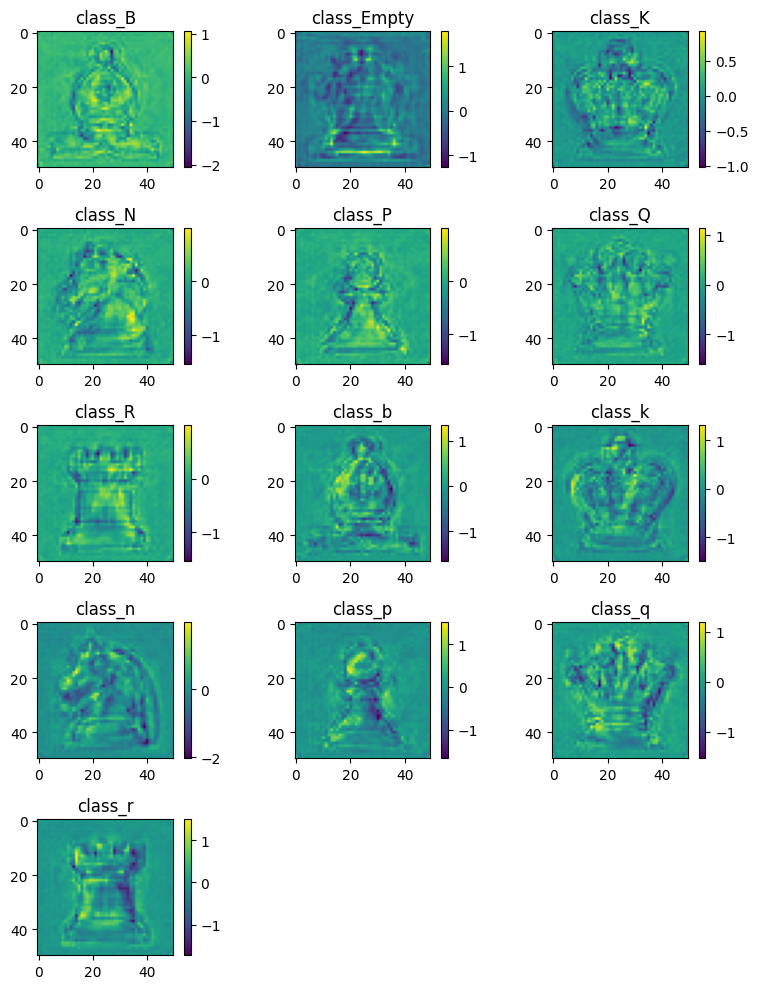

In [354]:
fig, axs = plt.subplots(5,3, figsize=(8,10))
axs = np.ravel(axs)
for i, classname in enumerate(class_names):
    axs[i].title.set_text(classname)
    img = axs[i].imshow(model.trainable_variables[0][:,i].numpy().reshape(50,50))
    plt.colorbar(img, ax=axs[i])
[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]
plt.tight_layout()
plt.show()

<Axes: ylabel='Frequency'>

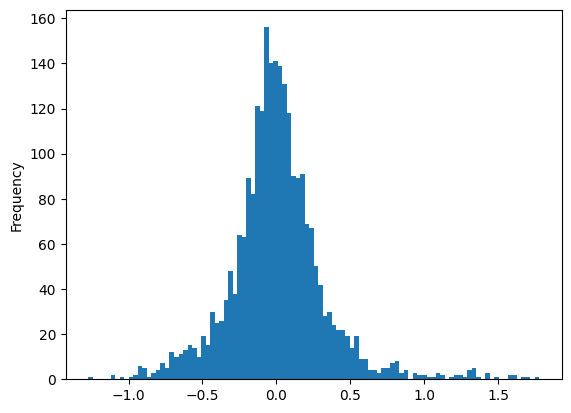

In [389]:
pd.Series(weights.ravel()).plot.hist(bins=100)

## Fullsize figure perceptron

In [503]:
train_ds, val_ds, class_names = load_dataset(FIGURE_PATH)
list(enumerate(class_names))

Found 140000 files belonging to 7 classes.
Using 112000 files for training.
Found 140000 files belonging to 7 classes.
Using 28000 files for validation.


[(0, 'class_b'),
 (1, 'class_empty'),
 (2, 'class_k'),
 (3, 'class_n'),
 (4, 'class_p'),
 (5, 'class_q'),
 (6, 'class_r')]

In [505]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.05),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=0.001)],
    epochs=100,
)

Epoch 1/100
438/438 [==============================] - 4s 7ms/step - loss: 4.0204 - accuracy: 0.8914 - val_loss: 0.0294 - val_accuracy: 0.9977 - lr: 0.0500
Epoch 2/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0214 - accuracy: 0.9984 - val_loss: 0.0147 - val_accuracy: 0.9998 - lr: 0.0500
Epoch 3/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0124 - accuracy: 0.9996 - val_loss: 0.0100 - val_accuracy: 0.9999 - lr: 0.0500
Epoch 4/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0089 - accuracy: 0.9998 - val_loss: 0.0075 - val_accuracy: 1.0000 - lr: 0.0500
Epoch 5/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0069 - accuracy: 0.9998 - val_loss: 0.0059 - val_accuracy: 1.0000 - lr: 0.0500
Epoch 6/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0055 - accuracy: 0.9999 - val_loss: 0.0048 - val_accuracy: 1.0000 - lr: 0.0500
Epoch 7/100
438/438 [==============================] - 1s 2ms/st

In [11]:
# TODO: move elsewhere?


In [507]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    model,
    tf.keras.layers.Softmax()
])
res = continous_eval(piece_test,tile_model)
(res != test.fen.str.upper()).sum()

0

In [508]:
model.save('./saved_models/fullsize_figure_perceptron.keras')

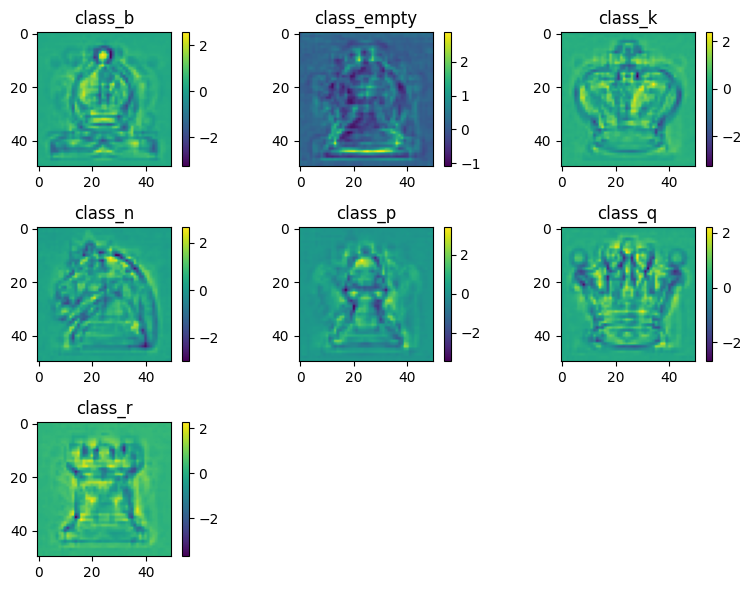

In [518]:
fig, axs = plt.subplots(3,3, figsize=(8,6))
axs = np.ravel(axs)
for i, classname in enumerate(class_names):
    axs[i].title.set_text(classname)
    img = axs[i].imshow(model.trainable_variables[0][:,i].numpy().reshape(50,50))
    plt.colorbar(img, ax=axs[i])
[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]
plt.tight_layout()
plt.show()

## Fullsize color perceptron

In [9]:
train_ds, val_ds, class_names = load_dataset(COLOR_PATH, label_mode='binary')
list(enumerate(class_names))

Found 120000 files belonging to 2 classes.
Using 96000 files for training.
Found 120000 files belonging to 2 classes.
Using 24000 files for validation.


[(0, 'class_black'), (1, 'class_white')]

In [11]:
num_classes = len(class_names)

color_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

color_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.05),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

color_model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=0.001)],
    epochs=100,
)

Epoch 1/100
375/375 [==============================] - 1s 3ms/step - loss: 0.5530 - accuracy: 0.9274 - val_loss: 0.0425 - val_accuracy: 0.9843 - lr: 0.0500
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0647 - accuracy: 0.9831 - val_loss: 0.0152 - val_accuracy: 0.9979 - lr: 0.0500
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 0.1515 - accuracy: 0.9729 - val_loss: 0.0131 - val_accuracy: 0.9967 - lr: 0.0500
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0570 - accuracy: 0.9862 - val_loss: 0.0096 - val_accuracy: 0.9980 - lr: 0.0500
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0053 - accuracy: 0.9993 - val_loss: 0.0063 - val_accuracy: 0.9998 - lr: 0.0500
Epoch 6/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.0041 - val_accuracy: 1.0000 - lr: 0.0500
Epoch 7/100
375/375 [==============================] - 1s 2ms/st

In [13]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    color_model,
])

continous_eval_color(test, tile_model)

0         True
1         True
2         True
3         True
4         True
          ... 
199651    True
199652    True
199653    True
199654    True
199655    True
Length: 199656, dtype: bool

In [14]:
color_model.save('./saved_models/fullsize_color_perceptron.keras')

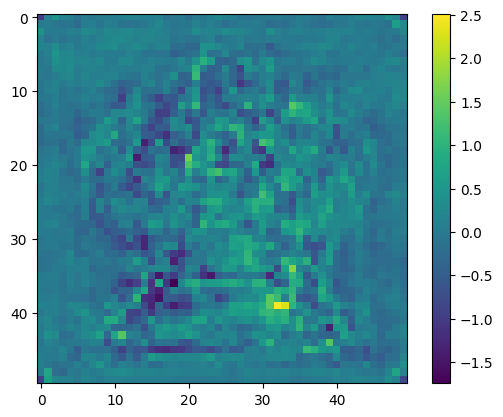

In [601]:
plt.imshow(color_model.trainable_variables[0][:,0].numpy().reshape(50,50))
plt.colorbar()
plt.show()

## Figure smaller MLP 

In [ ]:
train_ds, val_ds, class_names = load_dataset(FIGURE_PATH)
list(enumerate(class_names))

### Dense(4) hidden layer

In [81]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    #callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=0.001)],
    epochs=100,
)

Epoch 1/100
438/438 [==============================] - 2s 3ms/step - loss: 1.6956 - accuracy: 0.3126 - val_loss: 1.4792 - val_accuracy: 0.4320
Epoch 2/100
438/438 [==============================] - 1s 3ms/step - loss: 1.3402 - accuracy: 0.4729 - val_loss: 1.2095 - val_accuracy: 0.5708
Epoch 3/100
438/438 [==============================] - 1s 2ms/step - loss: 1.1016 - accuracy: 0.6868 - val_loss: 0.9906 - val_accuracy: 0.7979
Epoch 4/100
438/438 [==============================] - 1s 3ms/step - loss: 0.8991 - accuracy: 0.8165 - val_loss: 0.8047 - val_accuracy: 0.8556
Epoch 5/100
438/438 [==============================] - 1s 3ms/step - loss: 0.7340 - accuracy: 0.8654 - val_loss: 0.6603 - val_accuracy: 0.8864
Epoch 6/100
438/438 [==============================] - 1s 3ms/step - loss: 0.6076 - accuracy: 0.8927 - val_loss: 0.5513 - val_accuracy: 0.9113
Epoch 7/100
438/438 [==============================] - 1s 3ms/step - loss: 0.5114 - accuracy: 0.9156 - val_loss: 0.4674 - val_accuracy: 0.9266

In [82]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    model,
    tf.keras.layers.Softmax()
])
res = continous_eval(piece_test,tile_model, ret_on_fail=True)
res

0        5R2/8/3N4/4Q2N/6P1/1P1K1B1K/1Q2R1P1/5N2
1          3R3B/4P2N/3R4/8/P5K1/2BNK3/5N1R/3Q2R1
2             N2R1R2/2R5/K1P3R1/2P5/8/K7/PR4BP/8
3               5N2/5P2/1P5N/8/5B1P/8/P2P4/3KN2K
4                 4KQ2/K6B/2N3P1/4B3/3NP2N/8/8/8
                          ...                   
19995            1K6/8/3R2BQ/3N4/4N3/6K1/5Q2/5R2
19996       3B4/3PR2P/5P2/2N3QK/NB3BP1/N6K/3N4/8
19997            2R3K1/8/8/4PQ1B/8/7B/7N/1B2RK1Q
19998              8/3N4/1Q1N3B/8/8/K2N3K/R7/4B3
19999          4K3/5NN1/P7/4P3/4B3/1KPP4/3P4/5Q2
Length: 20000, dtype: object

In [83]:
model.save('./saved_models/fullsize_figure_mlp_4hidden.keras')

In [22]:
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_29 (Rescaling)    (None, 50, 50, 1)         0         
                                                                 
 flatten_29 (Flatten)        (None, 2500)              0         
                                                                 
 dense_56 (Dense)            (None, 4)                 10004     
                                                                 
 dense_57 (Dense)            (None, 7)                 35        
                                                                 
Total params: 10039 (39.21 KB)
Trainable params: 10039 (39.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Dense(3) more hidden layers failed

In [107]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    #callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=0.001)],
    epochs=100,
)

Epoch 1/100
438/438 [==============================] - 2s 3ms/step - loss: 1.8257 - accuracy: 0.2388 - val_loss: 1.6946 - val_accuracy: 0.3328
Epoch 2/100
438/438 [==============================] - 1s 3ms/step - loss: 1.5720 - accuracy: 0.4095 - val_loss: 1.4545 - val_accuracy: 0.4850
Epoch 3/100
438/438 [==============================] - 1s 3ms/step - loss: 1.3518 - accuracy: 0.5331 - val_loss: 1.2539 - val_accuracy: 0.5672
Epoch 4/100
438/438 [==============================] - 1s 3ms/step - loss: 1.1700 - accuracy: 0.6050 - val_loss: 1.0864 - val_accuracy: 0.6383
Epoch 5/100
438/438 [==============================] - 1s 3ms/step - loss: 1.0124 - accuracy: 0.6700 - val_loss: 0.9365 - val_accuracy: 0.6990
Epoch 6/100
438/438 [==============================] - 1s 3ms/step - loss: 0.8671 - accuracy: 0.7280 - val_loss: 0.7995 - val_accuracy: 0.7473
Epoch 7/100
438/438 [==============================] - 1s 3ms/step - loss: 0.7330 - accuracy: 0.7775 - val_loss: 0.6743 - val_accuracy: 0.7899

In [114]:
model.fit(
    train_ds,
    validation_data=val_ds,
    #callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=0.001)],
    epochs=50,
)

Epoch 1/50
438/438 [==============================] - 2s 3ms/step - loss: 3.5314e-05 - accuracy: 1.0000 - val_loss: 1.6304e-04 - val_accuracy: 1.0000
Epoch 2/50
438/438 [==============================] - 1s 3ms/step - loss: 3.3076e-05 - accuracy: 1.0000 - val_loss: 1.3333e-04 - val_accuracy: 1.0000
Epoch 3/50
438/438 [==============================] - 1s 3ms/step - loss: 3.0649e-05 - accuracy: 1.0000 - val_loss: 1.0148e-04 - val_accuracy: 1.0000
Epoch 4/50
438/438 [==============================] - 1s 3ms/step - loss: 2.9271e-05 - accuracy: 1.0000 - val_loss: 6.6808e-05 - val_accuracy: 1.0000
Epoch 5/50
438/438 [==============================] - 1s 3ms/step - loss: 2.9431e-05 - accuracy: 1.0000 - val_loss: 5.3262e-05 - val_accuracy: 1.0000
Epoch 6/50
438/438 [==============================] - 1s 3ms/step - loss: 2.7998e-05 - accuracy: 1.0000 - val_loss: 4.7334e-05 - val_accuracy: 1.0000
Epoch 7/50
438/438 [==============================] - 1s 3ms/step - loss: 2.5007e-05 - accuracy: 1.0

In [115]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    model,
    tf.keras.layers.Softmax()
])
res = continous_eval(piece_test, tile_model, ret_on_fail=True)
res

Error 1.
True: 5N2/5P2/1P5N/8/5B1P/8/P2P4/3KN2K
Pred: 5N2/5P2/1P5N/2R5/5B1P/8/P2P4/2RKN2K


## Figure MLP with segments

In [25]:
class Segmenter2D(tf.keras.layers.Layer):
    def __init__(self, segment_count, **kwargs):
        super(Segmenter2D, self).__init__(**kwargs)
        self.segment_count = segment_count

    def call(self, inputs):
        segment_shape = inputs.shape[1]//self.segment_count
        segments = tf.image.extract_patches(
            images=inputs,
            sizes=[1, segment_shape, segment_shape, 1],
            strides=[1, segment_shape, segment_shape, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        return segments

    def get_config(self):
        config = super(Segmenter2D, self).get_config()
        config.update({
            "segment_count": self.segment_count,
        })
        return config


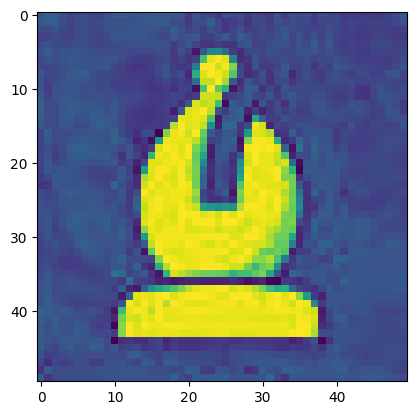

In [27]:
img2 = segment_image(load_image(train.path[0]))[0,3]
plt.imshow(img2)
plt.show()

(625,)


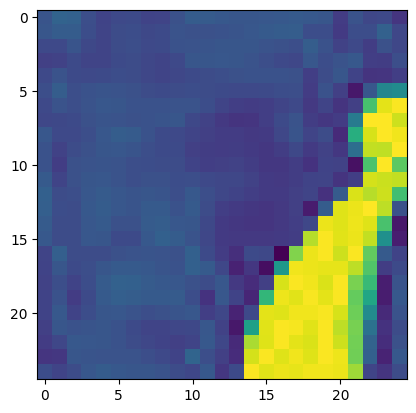

In [28]:
res = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    Segmenter2D(2),
])(np.array([img,img2]))
tile = res[1,0,0]
print(tile.shape)
tile = tf.reshape(tile, (25,25))
plt.imshow(tile)

In [7]:
class Segmenter2DWithModels(tf.keras.layers.Layer):
    def __init__(self, segment_count, models, **kwargs):
        super(Segmenter2DWithModels, self).__init__(**kwargs)
        self.segment_count = segment_count
        self.models = models

    def call(self, inputs):
        segment_shape = inputs.shape[1]//self.segment_count
        segments = tf.image.extract_patches(
            images=inputs,
            sizes=[1, segment_shape, segment_shape, 1],
            strides=[1, segment_shape, segment_shape, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        model_res = [self.models[y][x](segments[:,y,x]) for y in range(self.segment_count) for x in range(self.segment_count)] 
        return tf.concat(model_res, axis=1)

    def get_config(self):
        config = super(Segmenter2DWithModels, self).get_config()
        config.update({
            "segment_count": self.segment_count,
            "models": self.models,
        })
        return config


### 2x2x2 Segment encoder

In [5]:
train_ds, val_ds, class_names = load_dataset(FIGURE_PATH)
list(enumerate(class_names))

Found 140000 files belonging to 7 classes.
Using 112000 files for training.
Found 140000 files belonging to 7 classes.
Using 28000 files for validation.


[(0, 'class_b'),
 (1, 'class_empty'),
 (2, 'class_k'),
 (3, 'class_n'),
 (4, 'class_p'),
 (5, 'class_q'),
 (6, 'class_r')]

In [38]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    tf.keras.layers.Rescaling(1./255),
    Segmenter2DWithModels(2, [
        [tf.keras.layers.Dense(2, activation='relu'), tf.keras.layers.Dense(2, activation='relu')],
        [tf.keras.layers.Dense(2, activation='relu'), tf.keras.layers.Dense(2, activation='relu')]
    ]),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 50, 50, 1)         0         
                                                                 
 segmenter2d_with_models_3   (None, 8)                 5008      
 (Segmenter2DWithModels)                                         
                                                                 
 dense_75 (Dense)            (None, 7)                 63        
                                                                 
Total params: 5071 (19.81 KB)
Trainable params: 5071 (19.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
438/438 [==============================] - 12s 23ms/step - loss: 1.7419 - accuracy: 0.3273 - val_loss: 1.5486 - val_accuracy: 0.4903
Epoch 2/100
438/438 [==============================] - 1s 3ms/step - los

In [39]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

Epoch 1/100
438/438 [==============================] - 2s 4ms/step - loss: 0.0033 - accuracy: 0.9998 - val_loss: 0.0033 - val_accuracy: 0.9999
Epoch 2/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0032 - accuracy: 0.9998 - val_loss: 0.0032 - val_accuracy: 0.9999
Epoch 3/100
438/438 [==============================] - 2s 3ms/step - loss: 0.0031 - accuracy: 0.9998 - val_loss: 0.0031 - val_accuracy: 0.9999
Epoch 4/100
438/438 [==============================] - 2s 4ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 0.0030 - val_accuracy: 0.9999
Epoch 5/100
438/438 [==============================] - 2s 4ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.0029 - val_accuracy: 0.9999
Epoch 6/100
438/438 [==============================] - 2s 4ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 0.0028 - val_accuracy: 0.9999
Epoch 7/100
438/438 [==============================] - 2s 4ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 0.0028 - val_accuracy: 0.9999

In [42]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    model,
    tf.keras.layers.Softmax()
])
res = continous_eval(piece_test, tile_model, ret_on_fail=True)
res

0        5R2/8/3N4/4Q2N/6P1/1P1K1B1K/1Q2R1P1/5N2
1          3R3B/4P2N/3R4/8/P5K1/2BNK3/5N1R/3Q2R1
2             N2R1R2/2R5/K1P3R1/2P5/8/K7/PR4BP/8
3               5N2/5P2/1P5N/8/5B1P/8/P2P4/3KN2K
4                 4KQ2/K6B/2N3P1/4B3/3NP2N/8/8/8
                          ...                   
19995            1K6/8/3R2BQ/3N4/4N3/6K1/5Q2/5R2
19996       3B4/3PR2P/5P2/2N3QK/NB3BP1/N6K/3N4/8
19997            2R3K1/8/8/4PQ1B/8/7B/7N/1B2RK1Q
19998              8/3N4/1Q1N3B/8/8/K2N3K/R7/4B3
19999          4K3/5NN1/P7/4P3/4B3/1KPP4/3P4/5Q2
Length: 20000, dtype: object

In [ ]:
model.save('./saved_models/fullsize_figure_segencoder2x2x2.keras')

### Heterogenous 4x4 Segment encoder

In [13]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    tf.keras.layers.Rescaling(1./255),
    Segmenter2DWithModels(4, [
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu')],
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(2, activation='relu'), tf.keras.layers.Dense(2, activation='relu'), tf.keras.layers.Dense(1, activation='relu')],
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(2, activation='relu'), tf.keras.layers.Dense(2, activation='relu'), tf.keras.layers.Dense(1, activation='relu')],
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu')],
    ]),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 50, 50, 1)         0         
                                                                 
 segmenter2d_with_models_2   (None, 20)                2900      
 (Segmenter2DWithModels)                                         
                                                                 
 dense_50 (Dense)            (None, 7)                 147       
                                                                 
Total params: 3047 (11.90 KB)
Trainable params: 3047 (11.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
438/438 [==============================] - 6s 6ms/step - loss: 1.5505 - accuracy: 0.5431 - val_loss: 1.1363 - val_accuracy: 0.7195
Epoch 2/100
438/438 [==============================] - 3s 6ms/step - loss: 

In [14]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    model,
    tf.keras.layers.Softmax()
])
res = continous_eval(piece_test, tile_model, ret_on_fail=True)
res

0        5R2/8/3N4/4Q2N/6P1/1P1K1B1K/1Q2R1P1/5N2
1          3R3B/4P2N/3R4/8/P5K1/2BNK3/5N1R/3Q2R1
2             N2R1R2/2R5/K1P3R1/2P5/8/K7/PR4BP/8
3               5N2/5P2/1P5N/8/5B1P/8/P2P4/3KN2K
4                 4KQ2/K6B/2N3P1/4B3/3NP2N/8/8/8
                          ...                   
19995            1K6/8/3R2BQ/3N4/4N3/6K1/5Q2/5R2
19996       3B4/3PR2P/5P2/2N3QK/NB3BP1/N6K/3N4/8
19997            2R3K1/8/8/4PQ1B/8/7B/7N/1B2RK1Q
19998              8/3N4/1Q1N3B/8/8/K2N3K/R7/4B3
19999          4K3/5NN1/P7/4P3/4B3/1KPP4/3P4/5Q2
Length: 20000, dtype: object

In [17]:
model.save('./saved_models/fullsize_figure_segencoder4x4xheterog.keras')

### Heterogenous 4x4 with filter failed

In [19]:
class Segmenter2DWithModelsAndFilter(tf.keras.layers.Layer):
    def __init__(self, segment_count, models, filter, **kwargs):
        super(Segmenter2DWithModelsAndFilter, self).__init__(**kwargs)
        self.segment_count = segment_count
        self.models = models
        self.filter = filter

    def call(self, inputs):
        segment_shape = inputs.shape[1]//self.segment_count
        segments = tf.image.extract_patches(
            images=inputs,
            sizes=[1, segment_shape, segment_shape, 1],
            strides=[1, segment_shape, segment_shape, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        model_res = [self.models[y][x](segments[:,y,x]) 
                     for y in range(self.segment_count) 
                     for x in range(self.segment_count) 
                     if self.filter[y][x] == 1] 
        return tf.concat(model_res, axis=1)

    def get_config(self):
        config = super(Segmenter2DWithModelsAndFilter, self).get_config()
        config.update({
            "segment_count": self.segment_count,
            "models": self.models,
            "filter": self.filter,
        })
        return config


In [87]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    tf.keras.layers.Rescaling(1./255),
    Segmenter2DWithModelsAndFilter(4, [
        [0, tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu')],
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(2, activation='relu'), tf.keras.layers.Dense(2, activation='relu'), tf.keras.layers.Dense(1, activation='relu')],
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(2, activation='relu'), tf.keras.layers.Dense(2, activation='relu'), tf.keras.layers.Dense(1, activation='relu')],
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu')],
    ], filter= [
        [0, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
    ]),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_28 (Rescaling)    (None, 50, 50, 1)         0         
                                                                 
 segmenter2d_with_models_an  (None, 19)                2755      
 d_filter_18 (Segmenter2DWi                                      
 thModelsAndFilter)                                              
                                                                 
 dense_361 (Dense)           (None, 7)                 140       
                                                                 
Total params: 2895 (11.31 KB)
Trainable params: 2895 (11.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
438/438 [==============================] - 6s 6ms/step - loss: 1.5592 - accuracy: 0.5019 - val_loss: 1.1298 - val_accuracy: 0.7363
Epoch 2/

In [89]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

Epoch 1/100
438/438 [==============================] - 3s 6ms/step - loss: 6.7516e-06 - accuracy: 1.0000 - val_loss: 3.0532e-05 - val_accuracy: 1.0000
Epoch 2/100
438/438 [==============================] - 3s 6ms/step - loss: 6.3371e-06 - accuracy: 1.0000 - val_loss: 2.9975e-05 - val_accuracy: 1.0000
Epoch 3/100
438/438 [==============================] - 3s 6ms/step - loss: 5.9088e-06 - accuracy: 1.0000 - val_loss: 2.9605e-05 - val_accuracy: 1.0000
Epoch 4/100
438/438 [==============================] - 3s 6ms/step - loss: 5.5269e-06 - accuracy: 1.0000 - val_loss: 2.9660e-05 - val_accuracy: 1.0000
Epoch 5/100
438/438 [==============================] - 3s 6ms/step - loss: 5.1808e-06 - accuracy: 1.0000 - val_loss: 2.9715e-05 - val_accuracy: 1.0000
Epoch 6/100
438/438 [==============================] - 3s 6ms/step - loss: 4.8287e-06 - accuracy: 1.0000 - val_loss: 2.8008e-05 - val_accuracy: 1.0000
Epoch 7/100
438/438 [==============================] - 3s 6ms/step - loss: 4.5229e-06 - accura

In [90]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    model,
    tf.keras.layers.Softmax()
])
res = continous_eval(piece_test, tile_model, ret_on_fail=True)
res

Error 1.
True: 5N2/5P2/1P5N/8/5B1P/8/P2P4/3KN2K
Pred: 5N2/5P2/1P5N/4K3/5B1P/8/P2P4/3KN2K


## Figure horizontal symmetry 

In [288]:
@tf.keras.saving.register_keras_serializable()
class SplitFlipAdd(tf.keras.layers.Layer):
    def __init__(self, axis=2, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        first, second = tf.split(inputs, 2, axis=self.axis)
        second_flipped = tf.image.flip_left_right(second) if self.axis == 2 else tf.image.flip_up_down(second)
        summed = first + second_flipped
        return summed

    def get_config(self):
        config = super().get_config()
        config.update({
            "axis": self.axis,
        })
        return config


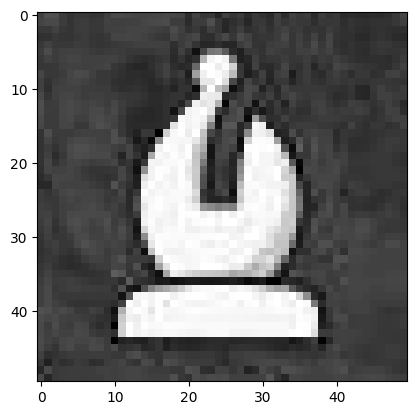

In [279]:
img = segment_image(load_image(train.path[0]))[0,3]
plt.imshow(img, cmap='gray')

(1, 50, 25, 1)


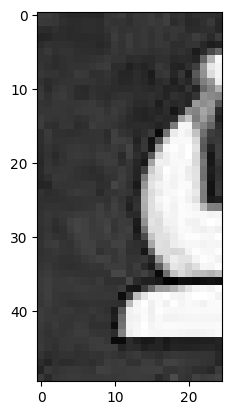

In [280]:
input_data = tf.reshape(img, (1, 50, 50, 1))
res = SplitFlipAdd(axis=2)(input_data/2)
print(res.shape)
plt.imshow(res[0], cmap='gray')

### Fullsize perceptron

In [21]:
train_ds, val_ds, class_names = load_dataset(FIGURE_PATH)
list(enumerate(class_names))

Found 140000 files belonging to 7 classes.
Using 112000 files for training.
Found 140000 files belonging to 7 classes.
Using 28000 files for validation.


[(0, 'class_b'),
 (1, 'class_empty'),
 (2, 'class_k'),
 (3, 'class_n'),
 (4, 'class_p'),
 (5, 'class_q'),
 (6, 'class_r')]

In [49]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    SplitFlipAdd(axis=2),
    tf.keras.layers.Rescaling(1./512),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

Epoch 1/100
438/438 [==============================] - 7s 15ms/step - loss: 0.8878 - accuracy: 0.8015 - val_loss: 0.4818 - val_accuracy: 0.9324
Epoch 2/100
438/438 [==============================] - 1s 2ms/step - loss: 0.3654 - accuracy: 0.9438 - val_loss: 0.2868 - val_accuracy: 0.9621
Epoch 3/100
438/438 [==============================] - 1s 2ms/step - loss: 0.2376 - accuracy: 0.9669 - val_loss: 0.2011 - val_accuracy: 0.9787
Epoch 4/100
438/438 [==============================] - 1s 2ms/step - loss: 0.1720 - accuracy: 0.9800 - val_loss: 0.1506 - val_accuracy: 0.9866
Epoch 5/100
438/438 [==============================] - 1s 2ms/step - loss: 0.1311 - accuracy: 0.9863 - val_loss: 0.1171 - val_accuracy: 0.9922
Epoch 6/100
438/438 [==============================] - 1s 2ms/step - loss: 0.1031 - accuracy: 0.9907 - val_loss: 0.0935 - val_accuracy: 0.9942
Epoch 7/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0829 - accuracy: 0.9937 - val_loss: 0.0762 - val_accuracy: 0.996

In [50]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    model,
    tf.keras.layers.Softmax()
])
res = continous_eval(piece_test, tile_model, ret_on_fail=True)
res

0        5R2/8/3N4/4Q2N/6P1/1P1K1B1K/1Q2R1P1/5N2
1          3R3B/4P2N/3R4/8/P5K1/2BNK3/5N1R/3Q2R1
2             N2R1R2/2R5/K1P3R1/2P5/8/K7/PR4BP/8
3               5N2/5P2/1P5N/8/5B1P/8/P2P4/3KN2K
4                 4KQ2/K6B/2N3P1/4B3/3NP2N/8/8/8
                          ...                   
19995            1K6/8/3R2BQ/3N4/4N3/6K1/5Q2/5R2
19996       3B4/3PR2P/5P2/2N3QK/NB3BP1/N6K/3N4/8
19997            2R3K1/8/8/4PQ1B/8/7B/7N/1B2RK1Q
19998              8/3N4/1Q1N3B/8/8/K2N3K/R7/4B3
19999          4K3/5NN1/P7/4P3/4B3/1KPP4/3P4/5Q2
Length: 20000, dtype: object

In [52]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 split_flip_add_24 (SplitFl  (None, 50, 25, 1)         0         
 ipAdd)                                                          
                                                                 
 rescaling_2 (Rescaling)     (None, 50, 25, 1)         0         
                                                                 
 flatten_2 (Flatten)         (None, 1250)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 8757      
                                                                 
Total params: 8757 (34.21 KB)
Trainable params: 8757 (34.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
model.save('./saved_models/splitflipadd_figure_perceptron.keras')

### Segmented encoder

In [321]:
class Segmenter2DWithModels(tf.keras.layers.Layer):
    def __init__(self, segment_count_x, segment_count_y, models, **kwargs):
        super(Segmenter2DWithModels, self).__init__(**kwargs)
        self.segment_count_x = segment_count_x
        self.segment_count_y = segment_count_y
        self.models = models

    def call(self, inputs):
        segment_height = inputs.shape[1]//self.segment_count_y
        segment_width = inputs.shape[2]//self.segment_count_x
        segments = tf.image.extract_patches(
            images=inputs,
            sizes=[1, segment_height, segment_width, 1],
            strides=[1, segment_height, segment_width, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        model_res = [self.models[y][x](segments[:,y,x]) for y in range(self.segment_count_y) for x in range(self.segment_count_x)] 
        return tf.concat(model_res, axis=1)

    def get_config(self):
        config = super(Segmenter2DWithModels, self).get_config()
        config.update({
            "segment_count_x": self.segment_count_x,
            "segment_count_y": self.segment_count_y,
            "models": self.models,
        })
        return config


In [311]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    SplitFlipAdd(axis=2),
    tf.keras.layers.Rescaling(1./512),
    Segmenter2DWithModels(2, 4, [
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(1, activation='relu')],
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(4, activation='relu')],
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(3, activation='relu')],
        [tf.keras.layers.Dense(1, activation='relu'), tf.keras.layers.Dense(3, activation='relu')],
    ]),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
)

Model: "sequential_184"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 split_flip_add_122 (SplitF  (None, 50, 25, 1)         0         
 lipAdd)                                                         
                                                                 
 rescaling_93 (Rescaling)    (None, 50, 25, 1)         0         
                                                                 
 segmenter2d_with_models_90  (None, 15)                2175      
  (Segmenter2DWithModels)                                        
                                                                 
 dense_801 (Dense)           (None, 7)                 112       
                                                                 
Total params: 2287 (8.93 KB)
Trainable params: 2287 (8.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
438/438 [

In [307]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
)

Epoch 1/25
438/438 [==============================] - 2s 4ms/step - loss: 8.7590e-04 - accuracy: 1.0000 - val_loss: 8.5195e-04 - val_accuracy: 1.0000
Epoch 2/25
438/438 [==============================] - 2s 4ms/step - loss: 8.2212e-04 - accuracy: 1.0000 - val_loss: 8.0279e-04 - val_accuracy: 1.0000
Epoch 3/25
438/438 [==============================] - 2s 4ms/step - loss: 7.7245e-04 - accuracy: 1.0000 - val_loss: 7.4898e-04 - val_accuracy: 1.0000
Epoch 4/25
438/438 [==============================] - 2s 4ms/step - loss: 7.2559e-04 - accuracy: 1.0000 - val_loss: 7.0227e-04 - val_accuracy: 1.0000
Epoch 5/25
438/438 [==============================] - 2s 4ms/step - loss: 6.8222e-04 - accuracy: 1.0000 - val_loss: 6.6325e-04 - val_accuracy: 1.0000
Epoch 6/25
438/438 [==============================] - 2s 4ms/step - loss: 6.4233e-04 - accuracy: 1.0000 - val_loss: 6.2213e-04 - val_accuracy: 1.0000
Epoch 7/25
438/438 [==============================] - 2s 4ms/step - loss: 6.0421e-04 - accuracy: 1.0

In [308]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    model,
    tf.keras.layers.Softmax()
])
res = continous_eval(piece_test, tile_model, ret_on_fail=True)
res

0        5R2/8/3N4/4Q2N/6P1/1P1K1B1K/1Q2R1P1/5N2
1          3R3B/4P2N/3R4/8/P5K1/2BNK3/5N1R/3Q2R1
2             N2R1R2/2R5/K1P3R1/2P5/8/K7/PR4BP/8
3               5N2/5P2/1P5N/8/5B1P/8/P2P4/3KN2K
4                 4KQ2/K6B/2N3P1/4B3/3NP2N/8/8/8
                          ...                   
19995            1K6/8/3R2BQ/3N4/4N3/6K1/5Q2/5R2
19996       3B4/3PR2P/5P2/2N3QK/NB3BP1/N6K/3N4/8
19997            2R3K1/8/8/4PQ1B/8/7B/7N/1B2RK1Q
19998              8/3N4/1Q1N3B/8/8/K2N3K/R7/4B3
19999          4K3/5NN1/P7/4P3/4B3/1KPP4/3P4/5Q2
Length: 20000, dtype: object

In [309]:
model.save('saved_models/splitflipadd_figure_segencoder_5.keras')

## Figure L1

In [231]:
num_classes = len(class_names)

mat_layer_kwargs = {
    'activation': 'relu',
    'kernel_regularizer': tf.keras.regularizers.L1(1e-6)
}

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    SplitFlipAdd(axis=2),
    tf.keras.layers.Rescaling(1./512),
    Segmenter2DWithModels(2, 4, [
        [tf.keras.layers.Dense(1, **mat_layer_kwargs), tf.keras.layers.Dense(1, **mat_layer_kwargs)],
        [tf.keras.layers.Dense(1, **mat_layer_kwargs), tf.keras.layers.Dense(4, **mat_layer_kwargs)],
        [tf.keras.layers.Dense(1, **mat_layer_kwargs), tf.keras.layers.Dense(3, **mat_layer_kwargs)],
        [tf.keras.layers.Dense(1, **mat_layer_kwargs), tf.keras.layers.Dense(3, **mat_layer_kwargs)],
    ]),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
)

Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 split_flip_add_65 (SplitFl  (None, 50, 25, 1)         0         
 ipAdd)                                                          
                                                                 
 rescaling_57 (Rescaling)    (None, 50, 25, 1)         0         
                                                                 
 segmenter2d_with_models_55  (None, 15)                2175      
  (Segmenter2DWithModels)                                        
                                                                 
 dense_471 (Dense)           (None, 7)                 112       
                                                                 
Total params: 2287 (8.93 KB)
Trainable params: 2287 (8.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
438/438 [

In [232]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
)

Epoch 1/25
438/438 [==============================] - 2s 5ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2/25
438/438 [==============================] - 2s 5ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 3/25
438/438 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 4/25
438/438 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 5/25
438/438 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/25
438/438 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/25
438/438 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 

In [233]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    model,
    tf.keras.layers.Softmax()
])
res = continous_eval(piece_test, tile_model, ret_on_fail=True)
res

0        5R2/8/3N4/4Q2N/6P1/1P1K1B1K/1Q2R1P1/5N2
1          3R3B/4P2N/3R4/8/P5K1/2BNK3/5N1R/3Q2R1
2             N2R1R2/2R5/K1P3R1/2P5/8/K7/PR4BP/8
3               5N2/5P2/1P5N/8/5B1P/8/P2P4/3KN2K
4                 4KQ2/K6B/2N3P1/4B3/3NP2N/8/8/8
                          ...                   
19995            1K6/8/3R2BQ/3N4/4N3/6K1/5Q2/5R2
19996       3B4/3PR2P/5P2/2N3QK/NB3BP1/N6K/3N4/8
19997            2R3K1/8/8/4PQ1B/8/7B/7N/1B2RK1Q
19998              8/3N4/1Q1N3B/8/8/K2N3K/R7/4B3
19999          4K3/5NN1/P7/4P3/4B3/1KPP4/3P4/5Q2
Length: 20000, dtype: object

In [315]:
model.save_weights('./saved_models/l1_sfa_segencoder.h5')

### Comparison

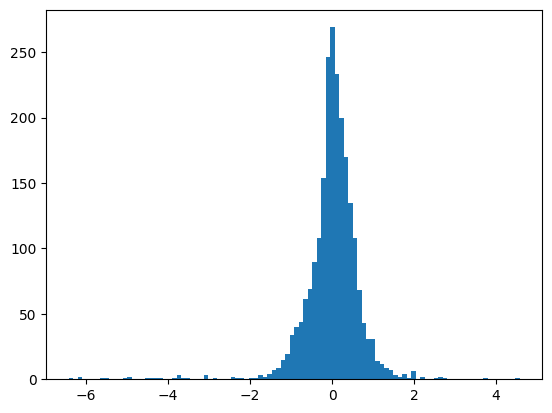

In [404]:
old_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    SplitFlipAdd(axis=2),
    tf.keras.layers.Rescaling(1./512),
    Segmenter2DWithModels(2, 4, [
        [tf.keras.layers.Dense(1, **mat_layer_kwargs), tf.keras.layers.Dense(1, **mat_layer_kwargs)],
        [tf.keras.layers.Dense(1, **mat_layer_kwargs), tf.keras.layers.Dense(4, **mat_layer_kwargs)],
        [tf.keras.layers.Dense(1, **mat_layer_kwargs), tf.keras.layers.Dense(3, **mat_layer_kwargs)],
        [tf.keras.layers.Dense(1, **mat_layer_kwargs), tf.keras.layers.Dense(3, **mat_layer_kwargs)],
    ]),
    tf.keras.layers.Dense(num_classes)
])
old_model.load_weights('./saved_models/splitflipadd_figure_segencoder_5.keras.h5')
old_ws = old_model.get_weights()
old_ws = np.concatenate([w.ravel() for w in old_ws])
plt.hist(old_ws, bins=100)
plt.show()

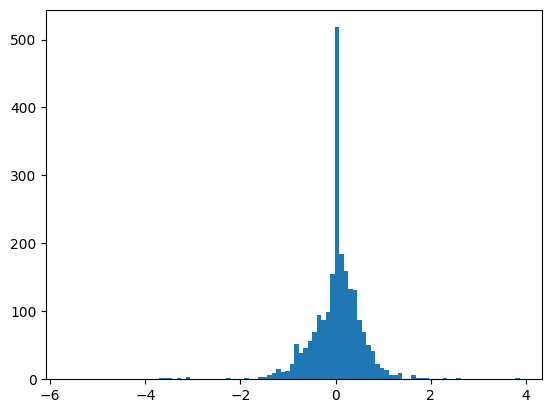

In [406]:
l1_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    SplitFlipAdd(axis=2),
    tf.keras.layers.Rescaling(1./512),
    Segmenter2DWithModels(2, 4, [
        [tf.keras.layers.Dense(1, **mat_layer_kwargs), tf.keras.layers.Dense(1, **mat_layer_kwargs)],
        [tf.keras.layers.Dense(1, **mat_layer_kwargs), tf.keras.layers.Dense(4, **mat_layer_kwargs)],
        [tf.keras.layers.Dense(1, **mat_layer_kwargs), tf.keras.layers.Dense(3, **mat_layer_kwargs)],
        [tf.keras.layers.Dense(1, **mat_layer_kwargs), tf.keras.layers.Dense(3, **mat_layer_kwargs)],
    ]),
    tf.keras.layers.Dense(num_classes)
])
l1_model.load_weights('./saved_models/l1_sfa_segencoder.h5')
l1_ws = l1_model.get_weights()
l1_ws = np.concatenate([w.ravel() for w in l1_ws])
plt.hist(l1_ws, bins=100)
plt.show()

In [411]:
ws = pd.concat([
    pd.Series(old_ws, name='old'), 
    pd.Series(l1_ws, name='l1')
], axis=1)
ws.describe()

,old,l1
count,2287.000000,2287.000000
mean,0.000842,0.003005
std,0.705618,0.650118
min,-6.424595,-5.610926
25%,-0.227260,-0.193619
50%,0.039533,0.001066
75%,0.333962,0.296308
max,4.571794,3.865977


## Color classifier optimization

### 2xSplitFLipAdd

In [437]:
train_ds, val_ds, class_names = load_dataset(COLOR_PATH, label_mode='binary')
list(enumerate(class_names))

Found 120000 files belonging to 2 classes.
Using 96000 files for training.
Found 120000 files belonging to 2 classes.
Using 24000 files for validation.


[(0, 'class_black'), (1, 'class_white')]

In [443]:
num_classes = len(class_names)

color_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    SplitFlipAdd(axis=2),
    SplitFlipAdd(axis=1),
    tf.keras.layers.Rescaling(1./512),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

color_model.summary()

color_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

color_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

Model: "sequential_182"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 split_flip_add_109 (SplitF  (None, 50, 25, 1)         0         
 lipAdd)                                                         
                                                                 
 split_flip_add_110 (SplitF  (None, 25, 25, 1)         0         
 lipAdd)                                                         
                                                                 
 rescaling_92 (Rescaling)    (None, 25, 25, 1)         0         
                                                                 
 flatten_4 (Flatten)         (None, 625)               0         
                                                                 
 dense_746 (Dense)           (None, 1)                 626       
                                                                 
Total params: 626 (2.45 KB)
Trainable params: 626 (2

In [444]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    color_model,
])

continous_eval_color(test, tile_model)

0         True
1         True
2         True
3         True
4         True
          ... 
199651    True
199652    True
199653    True
199654    True
199655    True
Length: 199656, dtype: bool

### 2xSplitFLipAdd + CenterCrop

In [553]:
num_classes = len(class_names)

color_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    tf.keras.layers.CenterCrop(26,22),
    SplitFlipAdd(axis=2),
    SplitFlipAdd(axis=1),
    tf.keras.layers.Rescaling(1./512),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

color_model.summary()

color_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

color_model.fit(
    train_ds,
    validation_data=val_ds,
    #callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-4)],
    epochs=50,
)

Model: "sequential_268"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_77 (CenterCrop  (None, 26, 22, 1)         0         
 )                                                               
                                                                 
 split_flip_add_281 (SplitF  (None, 26, 11, 1)         0         
 lipAdd)                                                         
                                                                 
 split_flip_add_282 (SplitF  (None, 13, 11, 1)         0         
 lipAdd)                                                         
                                                                 
 rescaling_172 (Rescaling)   (None, 13, 11, 1)         0         
                                                                 
 flatten_60 (Flatten)        (None, 143)               0         
                                                    

In [556]:
color_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
)

Epoch 1/25
375/375 [==============================] - 1s 3ms/step - loss: 8.0335e-04 - accuracy: 1.0000 - val_loss: 8.3737e-04 - val_accuracy: 1.0000
Epoch 2/25
375/375 [==============================] - 1s 4ms/step - loss: 7.6245e-04 - accuracy: 1.0000 - val_loss: 8.0277e-04 - val_accuracy: 1.0000
Epoch 3/25
375/375 [==============================] - 1s 3ms/step - loss: 7.3741e-04 - accuracy: 1.0000 - val_loss: 7.7326e-04 - val_accuracy: 1.0000
Epoch 4/25
375/375 [==============================] - 1s 4ms/step - loss: 7.1409e-04 - accuracy: 1.0000 - val_loss: 7.4671e-04 - val_accuracy: 1.0000
Epoch 5/25
375/375 [==============================] - 1s 3ms/step - loss: 6.9229e-04 - accuracy: 1.0000 - val_loss: 7.2226e-04 - val_accuracy: 1.0000
Epoch 6/25
375/375 [==============================] - 1s 3ms/step - loss: 6.7183e-04 - accuracy: 1.0000 - val_loss: 6.9949e-04 - val_accuracy: 1.0000
Epoch 7/25
375/375 [==============================] - 1s 3ms/step - loss: 6.5259e-04 - accuracy: 1.0

In [557]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    color_model,
])

continous_eval_color(test, tile_model, ret_on_fail=True)

2024-06-11 02:35:19.612772: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: sequential_270/sequential_268/center_crop_77/cond/branch_executed/_9


0         True
1         True
2         True
3         True
4         True
          ... 
199651    True
199652    True
199653    True
199654    True
199655    True
Length: 199656, dtype: bool

In [558]:
color_model.save_weights('./saved_models/cropped_2sfa_color_perceptron.h5')

### 2xSplitFLlpAdd + CenterCrop + L1

In [624]:
num_classes = len(class_names)

color_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    tf.keras.layers.CenterCrop(26,22),
    SplitFlipAdd(axis=2),
    SplitFlipAdd(axis=1),
    tf.keras.layers.Rescaling(1./512),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(1e-6))
])

color_model.summary()

color_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

color_model.fit(
    train_ds,
    validation_data=val_ds,
    #callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-4)],
    epochs=50,
)

Model: "sequential_304"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_92 (CenterCrop  (None, 26, 22, 1)         0         
 )                                                               
                                                                 
 split_flip_add_311 (SplitF  (None, 26, 11, 1)         0         
 lipAdd)                                                         
                                                                 
 split_flip_add_312 (SplitF  (None, 13, 11, 1)         0         
 lipAdd)                                                         
                                                                 
 rescaling_187 (Rescaling)   (None, 13, 11, 1)         0         
                                                                 
 flatten_75 (Flatten)        (None, 143)               0         
                                                    

In [625]:
color_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

Epoch 1/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0118 - accuracy: 0.9999 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 2/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0113 - accuracy: 0.9999 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 3/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0108 - accuracy: 0.9999 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 4/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0104 - accuracy: 0.9999 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 5/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0099 - accuracy: 0.9999 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 6/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0095 - accuracy: 0.9999 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 7/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0091 - accuracy: 0.9999 - val_loss: 0.0088 - val_accuracy: 1.0000

In [626]:
color_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

Epoch 1/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000

In [628]:
color_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

Epoch 1/100
375/375 [==============================] - 1s 3ms/step - loss: 5.7545e-04 - accuracy: 1.0000 - val_loss: 6.1157e-04 - val_accuracy: 1.0000
Epoch 2/100
375/375 [==============================] - 2s 4ms/step - loss: 5.7336e-04 - accuracy: 1.0000 - val_loss: 6.0933e-04 - val_accuracy: 1.0000
Epoch 3/100
375/375 [==============================] - 1s 4ms/step - loss: 5.7129e-04 - accuracy: 1.0000 - val_loss: 6.0712e-04 - val_accuracy: 1.0000
Epoch 4/100
375/375 [==============================] - 1s 4ms/step - loss: 5.6925e-04 - accuracy: 1.0000 - val_loss: 6.0493e-04 - val_accuracy: 1.0000
Epoch 5/100
375/375 [==============================] - 1s 4ms/step - loss: 5.6722e-04 - accuracy: 1.0000 - val_loss: 6.0277e-04 - val_accuracy: 1.0000
Epoch 6/100
375/375 [==============================] - 1s 4ms/step - loss: 5.6522e-04 - accuracy: 1.0000 - val_loss: 6.0063e-04 - val_accuracy: 1.0000
Epoch 7/100
375/375 [==============================] - 1s 4ms/step - loss: 5.6324e-04 - accura

In [631]:
tile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    color_model,
])

continous_eval_color(test, tile_model, ret_on_fail=True)

2024-06-11 07:26:06.483090: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: sequential_308/sequential_304/center_crop_92/cond/branch_executed/_9


0         True
1         True
2         True
3         True
4         True
          ... 
199651    True
199652    True
199653    True
199654    True
199655    True
Length: 199656, dtype: bool

In [632]:
color_model.save_weights('./saved_models/l1_cropped_2sfa_color_perceptron.h5')

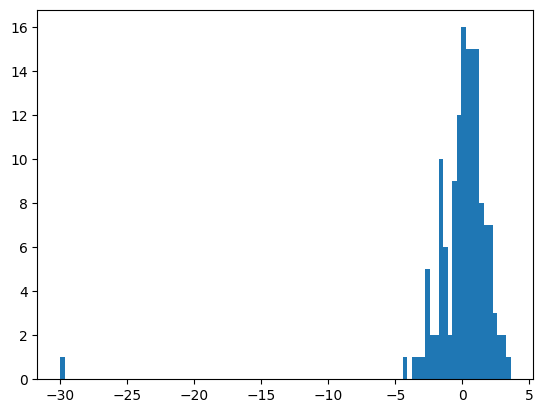

In [623]:
old_model = color_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,50,1)),
    tf.keras.layers.CenterCrop(26,22),
    SplitFlipAdd(axis=2),
    SplitFlipAdd(axis=1),
    tf.keras.layers.Rescaling(1./512),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(1e-7))
])
old_model.load_weights('./saved_models/cropped_2sfa_color_perceptron.h5')

old_ws = old_model.get_weights()
old_ws = np.concatenate([w.ravel() for w in old_ws])
plt.hist(old_ws, bins=100)
plt.show()

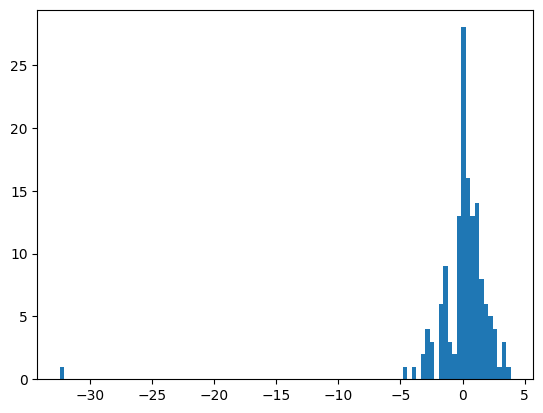

In [634]:
l1_ws = color_model.get_weights()
l1_ws = np.concatenate([w.ravel() for w in l1_ws])
plt.hist(l1_ws, bins=100)
plt.show()

## End